# Tutorial 01: Running Sumo/Flow Simulations

This tutorial walks a reader through setting up a simulation environment, initializing an attacking model, and subsequently running a simulation to understand the behavior of the simulation.

## Initialize the simulation environment: The Ring Road


We will beging with one of the simplest traffic simulation environments, the ringroad. On a ring, a finite number of vehicles following one another. First, we must import the proper network file, in this case `RingNetwork`:

In [2]:
from flow.networks.ring import RingNetwork

This network, as well as all other networks in Flow/Anti-Flow, is parametrized by the following arguments: 
* name
* vehicles
* net_params
* initial_config
* traffic_lights

The following code shows how to initialize these quantities:

In [3]:
#Import different needed quantities:
from flow.core.params import VehicleParams
from flow.controllers.car_following_models import IDMController #Human driving model
from flow.controllers.routing_controllers import ContinuousRouter #Router that keeps vehicles on the ring-road
from flow.networks.ring import ADDITIONAL_NET_PARAMS
from flow.core.params import NetParams
from flow.core.params import InitialConfig
from flow.core.params import TrafficLightParams
from flow.envs.ring.accel import AccelEnv
from flow.envs.ring.accel import ADDITIONAL_ENV_PARAMS
from flow.core.params import SumoParams
from flow.core.params import EnvParams
from flow.core.experiment import Experiment

print('Imports succesful.')

Imports succesful.


We now use the above imported objects to set up out simulation environemnt:

In [4]:
#Simulation parameters:
time_step = 0.1 #In seconds, how far each step of the simulation goes.
ring_length = 300 #The diameter of the ring-road
emission_path = 'data' #Where
want_render = True #If we want SUMO to render the environment and display the simulation.
sim_horizon = 3000 #How many simulation steps will be taken -> Runs for 300 seconds

#initialize the simulation using above parameters:
traffic_lights = TrafficLightParams() #This is empty, so no traffic lights are used.
initial_config = InitialConfig(spacing="uniform", perturbation=1) #Vehicles start out evenly spaced.
vehicles = VehicleParams() #The vehicles object will store different classes of drivers:
sim_params = SumoParams(sim_step=time_step, render=want_render, emission_path=emission_path) #Sets the simulation time-step and where data will be recorded.
env_params = EnvParams(additional_params=ADDITIONAL_ENV_PARAMS)
net_params = NetParams(additional_params={'length':ring_length,
                                          'lanes':1,
                                          'speed_limit': 30,
                                          'resolution': 40})

#Specify how human driven vehicles will drive:
num_human_drivers = 20
# Define a driver model human drivers:
vehicles.add("human",
             acceleration_controller=(IDMController, {'noise':0.1}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=num_human_drivers)


#initialize the simulation:
flow_params = dict(
    exp_tag='ring_no_attack',
    env_name=AccelEnv,
    network=RingNetwork,
    simulator='traci',
    sim=sim_params,
    env=env_params,
    net=net_params,
    veh=vehicles,
    initial=initial_config,
    tls=traffic_lights,
)

# number of time steps
flow_params['env'].horizon = sim_horizon
exp = Experiment(flow_params)
print('Simulation ready.')


Simulation ready.


Let's now run a simulation which doesn't have any malicious vehicles, and only human drivers:

In [10]:
#Run the simulation and save the data:
sim_res_list = exp.run(1, convert_to_csv=True)

Round 0, return: 2490.3460828534508
data/ring_no_attack_20211220-1235001640021700.908261-0_emission.csv data
Average, std returns: 2490.3460828534508, 0.0
Average, std velocities: 8.30408264804582, 0.0
Average, std outflows: 0.0, 0.0
Total time: 25.282506942749023
steps/second: 177.61400787442543


## Visualize simulation results:

First, we need to find the path to the experiment that was just run, which is stored in the exp object. Plotting tools for visualizing the traffic can then be used, which are found in flow\visualize. We plot the spacetime diagram which shows a slight travelling waves develop and then move backwards against the traffic flow.

Data loaded.


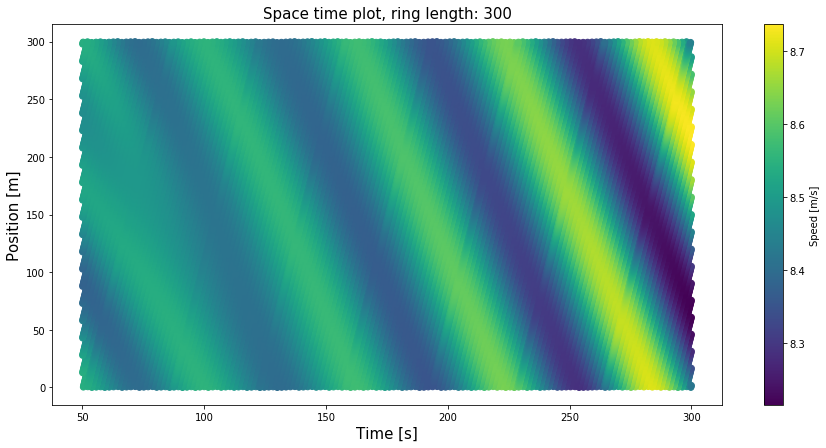

In [20]:
import os
import flow.visualize.visualize_ring as visualize_ring

emission_location = os.path.join(os.getcwd(),sim_res_list[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_location)

## Introduce an attacker:

Here we use the compromised model for an ACC which executes a randomized deceleration event (RDA). A single ACC vehicle is defined which has a given attack mangitude and duration. The attacker waits 50 seconds, and to travel 900 m before it executes its attack, and the attack is only executed once.

In [24]:
from flow.controllers.car_following_adversarial import ACC_Switched_Controller_Attacked_Single

attack_duration = 10 #How long the vehicle will slow down for.
attack_magnitude = -1.5 #In m/s^2 how strong the braking event is.
adversary_ACC_controller = (ACC_Switched_Controller_Attacked_Single,{
    'warmup_steps':500,
    'distance_threshold_max':800,
    'Total_Attack_Duration':attack_duration,
    'attack_decel_rate':attack_magnitude,
    'display_attack_info':False,
    'V_m':15.0})

# Reinstantiate which vehicles are  being run:
vehicles = VehicleParams()

num_human_drivers = 19
# Same human driver model as previously:
vehicles.add("human",
             acceleration_controller=(IDMController, {'noise':0.1}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=num_human_drivers)

vehicles.add("AV_Adv",
             acceleration_controller=adversary_ACC_controller,
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=1)
             
#initialize the simulation:
flow_params = dict(
    exp_tag='ring_with_attack',
    env_name=AccelEnv,
    network=RingNetwork,
    simulator='traci',
    sim=sim_params,
    env=env_params,
    net=net_params,
    veh=vehicles,
    initial=initial_config,
    tls=traffic_lights,
)

# number of time steps
flow_params['env'].horizon = sim_horizon
exp = Experiment(flow_params)
print('Simulation ready.')             

Simulation ready.


Now we execute the simulation and visualize the results:

Attack ACC spawned : AV_Adv_0 warmup steps: 500 attack distance: 810.4163996711022
Round 0, return: 1973.2424637749457
data/ring_with_attack_20211220-1347521640026072.84748-0_emission.csv data
Average, std returns: 1973.2424637749457, 0.0
Average, std velocities: 7.17945820660524, 0.0
Average, std outflows: 0.0, 0.0
Total time: 24.202209949493408
steps/second: 189.49960996295366
Simulation complete.
Data loaded.


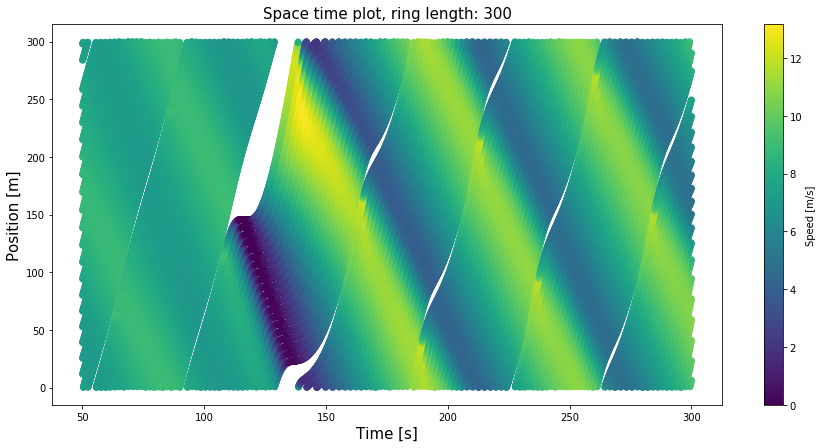

In [25]:
sim_res_list = exp.run(1, convert_to_csv=True)
print('Simulation complete.')

emission_location = os.path.join(os.getcwd(),sim_res_list[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_location)

The attack, which happens around position 150, and time 120, first brings traffic to a stand-still and subsequently creates a travelling wave of larger magnitude than the un-attacked traffic.

## Bibliography
[1] Sugiyama, Yuki, et al. "Traffic jams without bottlenecks—experimental evidence for the physical mechanism of the formation of a jam." New journal of physics 10.3 (2008): 033001.

[2] Treiber, Martin, Ansgar Hennecke, and Dirk Helbing. "Congested traffic states in empirical observations and microscopic simulations." Physical review E 62.2 (2000): 1805.